In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text # required to load from hub (even though pylance doesnt detect it)

from train_methods import *

tf.get_logger().setLevel('ERROR')

2023-12-04 01:59:12.414739: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 01:59:12.414773: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 01:59:12.414803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 01:59:12.423103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
pretrained_dir = '/hdd/logan/Joshua/causal_nlp/pretrained_models'
preprocessor_filename = 'bert_en_uncased_preprocess_3'
bert_filename = 'bert_en_uncased_L-12_H-768_A-12_4'
checkpoint_dir = '/hdd/logan/Joshua/causal_nlp/final_checkpoints'
trained_weights_filename = 'BERT_synthetic_noMMD'

# load text preprocessor
tfhub_handle_preprocess = hub.load(os.path.join(pretrained_dir, preprocessor_filename))
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

# load bert encoder
tfhub_handle_encoder = hub.load(os.path.join(pretrained_dir, bert_filename))
bert_model = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder')

# build model
model = build_augmented_model(bert_preprocess_model, bert_model, None)
model.compile(optimizer="adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = tf.metrics.SparseCategoricalAccuracy())

In [4]:
def load_eval_dataset(file_path: str, gamma: float,
                      text_key: str, cf_text_key: str,
                      confounder_key: str, label_key: str) -> tf.data.Dataset:
    """
    Returns a tensorflow dataset with
    - X: text inputs
    - X': counterfactual text inputs
    - Z: confounder inputs
    - Y: label ouputs
    - NOTE: resorted to doing this due to keras insisting all labels must have a seperate cost fn
    """
    with np.load(file_path, allow_pickle=True) as data:
        text = tf.convert_to_tensor(data[text_key], name=text_key)
        cf_text = tf.convert_to_tensor(data[cf_text_key], name=text_key)
        cf_flag = tf.convert_to_tensor(data[confounder_key], name=confounder_key, dtype=tf.int8)
        label = tf.convert_to_tensor(data[label_key], name=label_key, dtype=tf.int8)

    # evaluate the perterbation on loading
    N = text.shape[0]
    to_flip = np.random.random(N) < gamma

    # TENSORFLOW CANNOT SUPPORT BOOLEAN MASK ASSIGNMENT
    # text = input["text"]
    # cf_flag = input["confounder"]
    # text[to_flip] = input["cf_text"][to_flip]   # flip text
    # cf_flag[to_flip] = ~cf_flag[to_flip] + 2    # flip confounder label

    text = tf.where(to_flip, cf_text, text)
    cf_flag = tf.where(to_flip, ~cf_flag + 2, cf_flag)
    # note label should not flip -> due to counterfactual invariance property

    # generate dataset from perturbed data
    dataset = tf.data.Dataset.from_tensor_slices(
        ({"text": text,
          "label": label,
          "confounder": cf_flag},
          label))  # cast to int

    return dataset

In [5]:
def get_types_from_name(name: str):
    split_name = name.split('_')

    # find data set type
    dataset_type = split_name[1]

    # find mmd type
    if split_name[-1] == 'noMMD':
        mmd_type = None
    elif split_name[-3] == 'cMMD':
        mmd_type = ("conditional", float(split_name[-2] + '.' + split_name[-1]))
    elif split_name[-3] == 'mMMD':
        mmd_type = ("marginal", float(split_name[-2] + '.' + split_name[-1]))

    return dataset_type, mmd_type

def load_correct_datatype(dataset_type: str, gamma:float, batch_size: int,
                          data_dir = 'data',
                          test_syn_ds_filename = 'syn_test_small.npz',
                          test_nat_ds_filename = 'nat_val_small.npz'):
    if dataset_type == 'synthetic':
        test_ds_eval = load_eval_dataset(os.path.join(data_dir, test_syn_ds_filename), gamma=gamma,
                                        text_key='syntheticText', cf_text_key='cfSyntheticText',
                                        confounder_key='syntheticType', label_key='above3Stars')

    elif dataset_type == 'natural':
        test_ds_eval = load_eval_dataset(os.path.join(data_dir, test_nat_ds_filename), gamma=gamma,
                                        text_key='original_sentence', cf_text_key='flipped_sentence',
                                        confounder_key='above3Stars', label_key='aboveVThreshold')
    else:
        assert False, "Errornous dataset type detected!"

    return test_ds_eval.batch(batch_size)


In [14]:
from glob import glob
from tqdm import tqdm

data_dir = '/hdd/logan/Joshua/causal_nlp/data'
test_syn_ds_filename = 'syn_test_large.npz'
test_nat_ds_filename = 'nat_val_large.npz'

gammas = np.linspace(0.0,1.0, 6) # flip chance
batch_size = 64
np.random.seed(123) # make notebook results repeatable

results = {} # store results in a dictionary

files = glob(os.path.join(checkpoint_dir, '*.index'))
fbar = tqdm(files)
for file in fbar:
    dirNname, ext = os.path.splitext(file)
    _, name = os.path.split(dirNname)

    dataset_type, mmd_type = get_types_from_name(name)
    fbar.set_description(f"Dataset type: {dataset_type}, MMD Type: {mmd_type}")

    # load model
    model.load_weights(os.path.join(checkpoint_dir, name))

    # evaluate against perturb dataset for different gammas
    result_i = {}
    for gamma in tqdm(gammas, leave=False):

        # run accuracy test
        _, test_eval = model.evaluate(x=load_correct_datatype(dataset_type, gamma, batch_size,
                                                              data_dir, test_syn_ds_filename, test_nat_ds_filename))

        result_i[gamma] = test_eval

    # test label flip chance
    original_pred = model.predict(x = load_correct_datatype(dataset_type, 0.0, batch_size,
                                                            data_dir, test_syn_ds_filename, test_nat_ds_filename))
    flipped_pred = model.predict(x = load_correct_datatype(dataset_type, 1.0, batch_size,
                                                           data_dir, test_syn_ds_filename, test_nat_ds_filename))

    label_flip = tf.math.argmax(original_pred, axis=-1) != tf.math.argmax(flipped_pred, axis=-1)
    label_flip_chance = tf.math.reduce_mean(tf.cast(label_flip, tf.float32))

    results[(dataset_type, mmd_type)] = (result_i, label_flip_chance)

  0%|          | 0/14 [00:00<?, ?it/s]

Dataset type: synthetic, MMD Type: ('conditional', 1.0):   0%|          | 0/14 [00:00<?, ?it/s]

158/158 [==============================] - 38s 218ms/step - loss: 0.5243 - sparse_categorical_accuracy: 0.7750


158/158 [==============================] - 34s 218ms/step - loss: 0.5295 - sparse_categorical_accuracy: 0.7697


158/158 [==============================] - 34s 218ms/step - loss: 0.5366 - sparse_categorical_accuracy: 0.7601


158/158 [==============================] - 34s 218ms/step - loss: 0.5424 - sparse_categorical_accuracy: 0.7543


158/158 [==============================] - 34s 218ms/step - loss: 0.5481 - sparse_categorical_accuracy: 0.7444


158/158 [==============================] - 33s 207ms/step - loss: 0.5547 - sparse_categorical_accuracy: 0.7364


158/158 [==============================] - 32s 201ms/step


Dataset type: natural, MMD Type: ('conditional', 0.002):   7%|▋         | 1/14 [04:34<59:23, 274.09s/it]

105/105 [==============================] - 24s 224ms/step - loss: 0.5650 - sparse_categorical_accuracy: 0.6936


105/105 [==============================] - 23s 223ms/step - loss: 0.5651 - sparse_categorical_accuracy: 0.6954


105/105 [==============================] - 23s 224ms/step - loss: 0.5645 - sparse_categorical_accuracy: 0.6962


105/105 [==============================] - 24s 225ms/step - loss: 0.5656 - sparse_categorical_accuracy: 0.6939


105/105 [==============================] - 24s 224ms/step - loss: 0.5653 - sparse_categorical_accuracy: 0.6957


105/105 [==============================] - 23s 224ms/step - loss: 0.5654 - sparse_categorical_accuracy: 0.6975


105/105 [==============================] - 22s 208ms/step


Dataset type: synthetic, MMD Type: ('conditional', 0.002):  14%|█▍        | 2/14 [07:40<44:28, 222.41s/it]

158/158 [==============================] - 35s 219ms/step - loss: 0.5309 - sparse_categorical_accuracy: 0.7726


158/158 [==============================] - 35s 219ms/step - loss: 0.5354 - sparse_categorical_accuracy: 0.7671


158/158 [==============================] - 35s 219ms/step - loss: 0.5413 - sparse_categorical_accuracy: 0.7596


158/158 [==============================] - 35s 219ms/step - loss: 0.5467 - sparse_categorical_accuracy: 0.7533


158/158 [==============================] - 35s 219ms/step - loss: 0.5518 - sparse_categorical_accuracy: 0.7448


158/158 [==============================] - 35s 219ms/step - loss: 0.5570 - sparse_categorical_accuracy: 0.7382


158/158 [==============================] - 32s 203ms/step


Dataset type: natural, MMD Type: None:  21%|██▏       | 3/14 [12:13<45:00, 245.50s/it]                    

105/105 [==============================] - 23s 223ms/step - loss: 0.5704 - sparse_categorical_accuracy: 0.6878


105/105 [==============================] - 23s 223ms/step - loss: 0.5702 - sparse_categorical_accuracy: 0.6889


105/105 [==============================] - 23s 223ms/step - loss: 0.5701 - sparse_categorical_accuracy: 0.6877


105/105 [==============================] - 23s 223ms/step - loss: 0.5709 - sparse_categorical_accuracy: 0.6887


105/105 [==============================] - 23s 223ms/step - loss: 0.5698 - sparse_categorical_accuracy: 0.6911


105/105 [==============================] - 24s 224ms/step - loss: 0.5706 - sparse_categorical_accuracy: 0.6905


105/105 [==============================] - 22s 210ms/step


Dataset type: natural, MMD Type: ('marginal', 1.0):  29%|██▊       | 4/14 [15:19<36:58, 221.90s/it]

105/105 [==============================] - 24s 225ms/step - loss: 0.5844 - sparse_categorical_accuracy: 0.6760


105/105 [==============================] - 24s 225ms/step - loss: 0.5841 - sparse_categorical_accuracy: 0.6765


105/105 [==============================] - 24s 224ms/step - loss: 0.5828 - sparse_categorical_accuracy: 0.6772


105/105 [==============================] - 24s 225ms/step - loss: 0.5840 - sparse_categorical_accuracy: 0.6771


105/105 [==============================] - 24s 225ms/step - loss: 0.5831 - sparse_categorical_accuracy: 0.6801


105/105 [==============================] - 24s 225ms/step - loss: 0.5831 - sparse_categorical_accuracy: 0.6793


105/105 [==============================] - 22s 212ms/step


Dataset type: natural, MMD Type: ('conditional', 0.005):  36%|███▌      | 5/14 [18:26<31:24, 209.43s/it]

105/105 [==============================] - 24s 226ms/step - loss: 0.5656 - sparse_categorical_accuracy: 0.6915


105/105 [==============================] - 24s 225ms/step - loss: 0.5651 - sparse_categorical_accuracy: 0.6935


105/105 [==============================] - 24s 226ms/step - loss: 0.5653 - sparse_categorical_accuracy: 0.6942


105/105 [==============================] - 24s 227ms/step - loss: 0.5652 - sparse_categorical_accuracy: 0.6924


105/105 [==============================] - 24s 226ms/step - loss: 0.5656 - sparse_categorical_accuracy: 0.6929


105/105 [==============================] - 24s 226ms/step - loss: 0.5660 - sparse_categorical_accuracy: 0.6935


105/105 [==============================] - 22s 209ms/step


Dataset type: synthetic, MMD Type: ('marginal', 0.005):  43%|████▎     | 6/14 [21:34<26:57, 202.19s/it] 

158/158 [==============================] - 35s 221ms/step - loss: 0.5318 - sparse_categorical_accuracy: 0.7764


158/158 [==============================] - 35s 221ms/step - loss: 0.5374 - sparse_categorical_accuracy: 0.7689


158/158 [==============================] - 35s 221ms/step - loss: 0.5432 - sparse_categorical_accuracy: 0.7618


158/158 [==============================] - 35s 221ms/step - loss: 0.5484 - sparse_categorical_accuracy: 0.7542


158/158 [==============================] - 35s 220ms/step - loss: 0.5542 - sparse_categorical_accuracy: 0.7471


158/158 [==============================] - 35s 220ms/step - loss: 0.5593 - sparse_categorical_accuracy: 0.7384


158/158 [==============================] - 32s 204ms/step


Dataset type: natural, MMD Type: ('conditional', 1.0):  50%|█████     | 7/14 [26:09<26:22, 226.05s/it] 

105/105 [==============================] - 23s 224ms/step - loss: 0.5692 - sparse_categorical_accuracy: 0.6874


105/105 [==============================] - 23s 223ms/step - loss: 0.5684 - sparse_categorical_accuracy: 0.6898


105/105 [==============================] - 23s 223ms/step - loss: 0.5688 - sparse_categorical_accuracy: 0.6911


105/105 [==============================] - 23s 222ms/step - loss: 0.5685 - sparse_categorical_accuracy: 0.6886


105/105 [==============================] - 23s 223ms/step - loss: 0.5688 - sparse_categorical_accuracy: 0.6905


105/105 [==============================] - 24s 225ms/step - loss: 0.5693 - sparse_categorical_accuracy: 0.6907


105/105 [==============================] - 22s 209ms/step


Dataset type: synthetic, MMD Type: None:  57%|█████▋    | 8/14 [29:15<21:20, 213.33s/it]              

158/158 [==============================] - 35s 220ms/step - loss: 0.5398 - sparse_categorical_accuracy: 0.7702


158/158 [==============================] - 34s 218ms/step - loss: 0.5444 - sparse_categorical_accuracy: 0.7623


158/158 [==============================] - 35s 219ms/step - loss: 0.5498 - sparse_categorical_accuracy: 0.7566


158/158 [==============================] - 34s 218ms/step - loss: 0.5551 - sparse_categorical_accuracy: 0.7490


158/158 [==============================] - 35s 219ms/step - loss: 0.5601 - sparse_categorical_accuracy: 0.7407


158/158 [==============================] - 35s 220ms/step - loss: 0.5647 - sparse_categorical_accuracy: 0.7347


158/158 [==============================] - 32s 203ms/step


Dataset type: natural, MMD Type: ('marginal', 0.005):  64%|██████▍   | 9/14 [33:48<19:20, 232.04s/it]

105/105 [==============================] - 23s 223ms/step - loss: 0.5685 - sparse_categorical_accuracy: 0.6896


105/105 [==============================] - 23s 224ms/step - loss: 0.5688 - sparse_categorical_accuracy: 0.6895


105/105 [==============================] - 24s 224ms/step - loss: 0.5696 - sparse_categorical_accuracy: 0.6896


105/105 [==============================] - 24s 225ms/step - loss: 0.5694 - sparse_categorical_accuracy: 0.6932


105/105 [==============================] - 24s 225ms/step - loss: 0.5698 - sparse_categorical_accuracy: 0.6914


105/105 [==============================] - 24s 225ms/step - loss: 0.5694 - sparse_categorical_accuracy: 0.6929


105/105 [==============================] - 22s 211ms/step


Dataset type: synthetic, MMD Type: ('conditional', 0.005):  71%|███████▏  | 10/14 [36:55<14:32, 218.11s/it]

158/158 [==============================] - 35s 220ms/step - loss: 0.5315 - sparse_categorical_accuracy: 0.7735


158/158 [==============================] - 35s 219ms/step - loss: 0.5363 - sparse_categorical_accuracy: 0.7671


158/158 [==============================] - 35s 220ms/step - loss: 0.5423 - sparse_categorical_accuracy: 0.7584


158/158 [==============================] - 35s 220ms/step - loss: 0.5466 - sparse_categorical_accuracy: 0.7535


158/158 [==============================] - 35s 220ms/step - loss: 0.5523 - sparse_categorical_accuracy: 0.7451


158/158 [==============================] - 35s 220ms/step - loss: 0.5577 - sparse_categorical_accuracy: 0.7395


158/158 [==============================] - 32s 203ms/step


Dataset type: synthetic, MMD Type: ('marginal', 1.0):  79%|███████▊  | 11/14 [41:29<11:45, 235.24s/it]     

158/158 [==============================] - 35s 219ms/step - loss: 0.5482 - sparse_categorical_accuracy: 0.7746


158/158 [==============================] - 35s 219ms/step - loss: 0.5497 - sparse_categorical_accuracy: 0.7712


158/158 [==============================] - 35s 221ms/step - loss: 0.5507 - sparse_categorical_accuracy: 0.7696


158/158 [==============================] - 35s 221ms/step - loss: 0.5527 - sparse_categorical_accuracy: 0.7654


158/158 [==============================] - 35s 220ms/step - loss: 0.5540 - sparse_categorical_accuracy: 0.7632


158/158 [==============================] - 35s 220ms/step - loss: 0.5551 - sparse_categorical_accuracy: 0.7613


158/158 [==============================] - 32s 206ms/step


Dataset type: synthetic, MMD Type: ('marginal', 0.002):  86%|████████▌ | 12/14 [46:04<08:14, 247.26s/it]

158/158 [==============================] - 35s 220ms/step - loss: 0.5318 - sparse_categorical_accuracy: 0.7772


158/158 [==============================] - 35s 220ms/step - loss: 0.5370 - sparse_categorical_accuracy: 0.7701


158/158 [==============================] - 35s 220ms/step - loss: 0.5417 - sparse_categorical_accuracy: 0.7629


158/158 [==============================] - 35s 221ms/step - loss: 0.5479 - sparse_categorical_accuracy: 0.7544


158/158 [==============================] - 35s 219ms/step - loss: 0.5521 - sparse_categorical_accuracy: 0.7509


158/158 [==============================] - 35s 220ms/step - loss: 0.5573 - sparse_categorical_accuracy: 0.7417


158/158 [==============================] - 32s 206ms/step


Dataset type: natural, MMD Type: ('marginal', 0.002):  93%|█████████▎| 13/14 [50:39<04:15, 255.68s/it]  

105/105 [==============================] - 24s 225ms/step - loss: 0.5698 - sparse_categorical_accuracy: 0.6889


105/105 [==============================] - 24s 225ms/step - loss: 0.5702 - sparse_categorical_accuracy: 0.6908


105/105 [==============================] - 24s 226ms/step - loss: 0.5696 - sparse_categorical_accuracy: 0.6892


105/105 [==============================] - 24s 225ms/step - loss: 0.5704 - sparse_categorical_accuracy: 0.6910


105/105 [==============================] - 24s 225ms/step - loss: 0.5699 - sparse_categorical_accuracy: 0.6915


105/105 [==============================] - 24s 226ms/step - loss: 0.5700 - sparse_categorical_accuracy: 0.6924


105/105 [==============================] - 22s 210ms/step


Dataset type: natural, MMD Type: ('marginal', 0.002): 100%|██████████| 14/14 [53:47<00:00, 230.50s/it]


In [15]:
import pickle

# store data
pickle_name = 'results.pickle'
with open(os.path.join(checkpoint_dir, 'results.pickle'), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# optionally load results
with open(os.path.join(checkpoint_dir, 'results.pickle'), 'rb') as handle:
    results = pickle.load(handle)

Text(0.5, 0.98, 'Accuracy against Increasing Perturbation Strength')

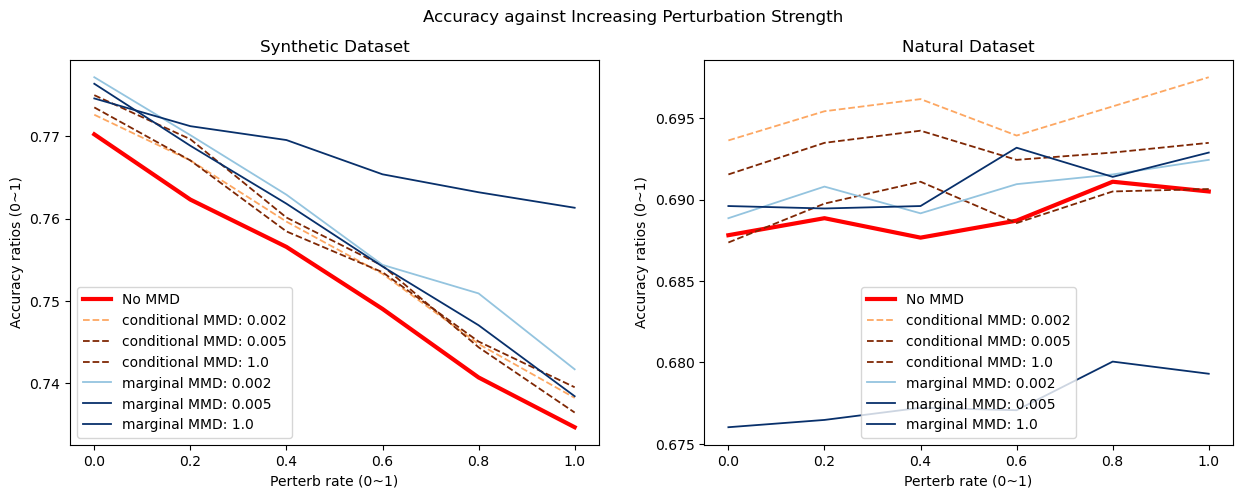

In [150]:
# plot results
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def sortfn(result_i):
    _, mmd_type = result_i[0]
    return ("",0) if mmd_type is None else mmd_type

sorted_results = sorted(results.items(), key=sortfn)

fig, (ax_syn, ax_nat) = plt.subplots(1, 2, figsize=(15.0, 5.0))
for (dataset_type, mmd_type), (acc_results, flip_chance) in sorted_results:
    x = acc_results.keys()
    y = acc_results.values()
    label = "No MMD" if mmd_type is None else f"{mmd_type[0]} MMD: {mmd_type[1]}"
    fmt = '--' if mmd_type is not None and mmd_type[0] == 'conditional' else '-'
    linewidth = 3.0 if mmd_type is None else 1.3
    if mmd_type is None:
        color = mpl.colors.BASE_COLORS['r']
    elif mmd_type[0] == 'conditional':
        color = mpl.colormaps['Oranges'](mmd_type[1] * 200)
    elif mmd_type[0] == 'marginal':
        color = mpl.colormaps['Blues'](mmd_type[1] * 200)

    ax_plt = ax_syn if dataset_type == 'synthetic' else ax_nat
    ax_plt.plot(x, y, fmt, label=label, linewidth=linewidth, color=color)

ax_syn.set_xlabel('Perterb rate (0~1)')
ax_nat.set_xlabel('Perterb rate (0~1)')
ax_syn.set_ylabel('Accuracy ratios (0~1)')
ax_nat.set_ylabel('Accuracy ratios (0~1)')
ax_syn.set_title('Synthetic Dataset')
ax_nat.set_title('Natural Dataset')
ax_syn.legend()
ax_nat.legend()
fig.suptitle('Accuracy against Increasing Perturbation Strength')

In [92]:
import pandas as pd


data = list(zip(*[(dataset_type, 'No MMD' if mmd_type is None else mmd_type[0], 0.0 if mmd_type is None else mmd_type[1], flip_chance.numpy()) for (dataset_type, mmd_type), (_, flip_chance) in sorted_results]))
df = pd.DataFrame({'Dataset Type':data[0], 'MMD Type':data[1], 'MMD Coeff':data[2], 'Flip Chance':data[3]})
df = df.sort_values(by='Dataset Type')
df

,Dataset Type,MMD Type,MMD Coeff,Flip Chance
0,natural,No MMD,0.000,0.055539
2,natural,conditional,0.002,0.051359
4,natural,conditional,0.005,0.048223
7,natural,conditional,1.000,0.052852
9,natural,marginal,0.002,0.051359
11,natural,marginal,0.005,0.056435
12,natural,marginal,1.000,0.037922
1,synthetic,No MMD,0.000,0.078600
3,synthetic,conditional,0.002,0.079592
5,synthetic,conditional,0.005,0.081376


Text(0.5, 0.98, 'Impact of Coefficient Strength on Label Flipping')

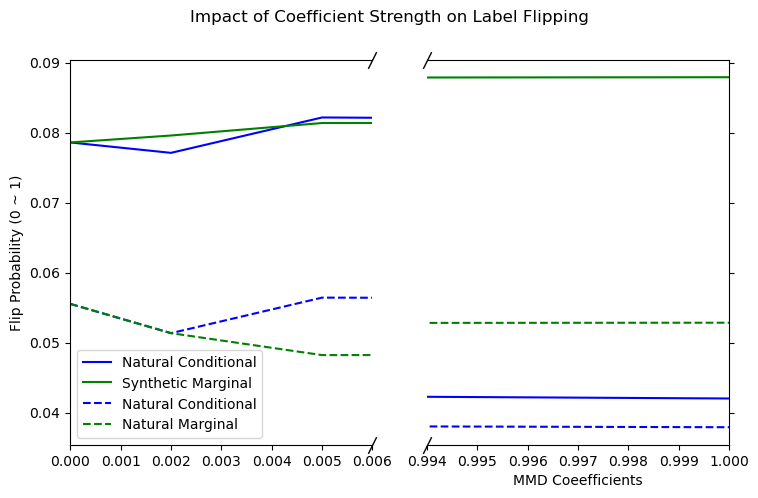

In [154]:
natural_conditional = df[(df['Dataset Type'] == 'natural') & (df['MMD Type'] != 'conditional')]
natural_marginal = df[(df['Dataset Type'] == 'natural') & (df['MMD Type'] != 'marginal')]
synthetic_conditional = df[(df['Dataset Type'] == 'synthetic') & (df['MMD Type'] != 'conditional')]
synthetic_marginal = df[(df['Dataset Type'] == 'synthetic') & (df['MMD Type'] != 'marginal')]

fig2, (l_ax, r_ax) = plt.subplots(1, 2, sharey=True, figsize=(8.5, 5.0))
fig2.subplots_adjust(wspace=0.18)

l_ax.plot(synthetic_conditional['MMD Coeff'], synthetic_conditional['Flip Chance'], 'b', label = 'Natural Conditional')
r_ax.plot(synthetic_conditional['MMD Coeff'], synthetic_conditional['Flip Chance'], 'b')
l_ax.plot(synthetic_marginal['MMD Coeff'], synthetic_marginal['Flip Chance'], 'g', label = 'Synthetic Marginal')
r_ax.plot(synthetic_marginal['MMD Coeff'], synthetic_marginal['Flip Chance'], 'g')

l_ax.plot(natural_conditional['MMD Coeff'], natural_conditional['Flip Chance'], 'b--', label = 'Natural Conditional')
r_ax.plot(natural_conditional['MMD Coeff'], natural_conditional['Flip Chance'], 'b--')
l_ax.plot(natural_marginal['MMD Coeff'], natural_marginal['Flip Chance'], 'g--', label = 'Natural Marginal')
r_ax.plot(natural_marginal['MMD Coeff'], natural_marginal['Flip Chance'], 'g--')



l_ax.set_xlim(0, 0.006)
r_ax.set_xlim(0.994, 1.00)

l_ax.spines.right.set_visible(False)
r_ax.spines.left.set_visible(False)
l_ax.yaxis.tick_left()
r_ax.yaxis.tick_right()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
l_ax.plot([1, 1], [0, 1], transform=l_ax.transAxes, **kwargs)
r_ax.plot([0, 0], [0, 1], transform=r_ax.transAxes, **kwargs)

l_ax.set_ylabel('Flip Probability (0 ~ 1)')
r_ax.set_xlabel('MMD Coeefficients')
l_ax.legend()
fig2.suptitle('Impact of Coefficient Strength on Label Flipping')